In [68]:
library(tidyverse)

library(patchwork)
library(ggplot2)

after federated clustering.

In [69]:
for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced")) {
    # Define the path and list all zip files
    path_to_fed <- paste0("../evaluation_data/simulated_rotation/", mode, "/after/fc_kmeans_res/")
    zip_files <- list.files(path = path_to_fed, pattern = "\\.zip$", full.names = TRUE)

    # Required file paths inside the zip archives
    required_files <- c(
      "kmeans/K_2/clustering.csv", "kmeans/K_3/clustering.csv"
      # "design.tsv"
    )
    print(paste0("Processing mode: ", mode, ", found ", length(zip_files), " zip files."))
    for (i in seq_along(zip_files)) {
      zipfile <- zip_files[i]
      zip_contents <- unzip(zipfile, list = TRUE)$Name

      # Process each required file within the zip archive
      for (req in required_files) {
        if (!req %in% zip_contents) {
          warning(sprintf("File '%s' not found in zip: %s", req, zipfile))
          next
        }

        # Extract the specific file to the destination folder
        unzip(zipfile, files = req, exdir = path_to_fed)

        # Determine the destination filename based on the required file
        # Extract the specific part ("2" or "5") from the path using a simple regex:
        match <- regexpr("K_([0-9]+)", req)
        extracted_num <- if (match[1] != -1) substring(req, match[1] + 2, match[1] + attr(match, "match.length") - 1) else "unknown"
        new_csv_name <- file.path(path_to_fed, sprintf("%d_%s_clustering.csv", i, extracted_num))

        # Determine the path to the extracted file (it might be in a subdirectory)
        extracted_csv_path <- file.path(path_to_fed, req)
        if (!file.exists(extracted_csv_path)) {
          # Search recursively if not found in the expected location
          extracted_files <- list.files(path_to_fed, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)
          candidate <- extracted_files[basename(extracted_files) == basename(req)]
          if (length(candidate) > 0) {
            extracted_csv_path <- candidate[1]
          } else {
            warning(sprintf("Extracted CSV file not found for '%s' in zip: %s", req, zipfile))
            next
          }
        }

        # Rename (or move) the extracted file to the new filename
        if (!file.rename(from = extracted_csv_path, to = new_csv_name)) {
          warning(sprintf("Failed to rename file: %s to %s", extracted_csv_path, new_csv_name))
        }
      }
    }
}


[1] "Processing mode: balanced, found 6 zip files."
[1] "Processing mode: mild_imbalanced, found 6 zip files."
[1] "Processing mode: strong_imbalanced, found 3 zip files."


In [70]:
for (mode in c(
    "balanced", 
    "mild_imbalanced", 
    "strong_imbalanced")) {
    # Define the path and list all zip files
    path_to_fed <- paste0("../evaluation_data/simulated_rotation/", mode, "/before_corrected/fc_kmeans_res/")
    zip_files <- list.files(path = path_to_fed, pattern = "\\.zip$", full.names = TRUE)

    # Required file paths inside the zip archives
    required_files <- c(
      "kmeans/K_2/clustering.csv", "kmeans/K_3/clustering.csv"
      # "design.tsv"
    )
    print(paste0("Processing mode: ", mode, ", found ", length(zip_files), " zip files."))
    for (i in seq_along(zip_files)) {
      zipfile <- zip_files[i]
      zip_contents <- unzip(zipfile, list = TRUE)$Name

      # Process each required file within the zip archive
      for (req in required_files) {
        if (!req %in% zip_contents) {
          warning(sprintf("File '%s' not found in zip: %s", req, zipfile))
          next
        }

        # Extract the specific file to the destination folder
        unzip(zipfile, files = req, exdir = path_to_fed)

        # Determine the destination filename based on the required file
        # Extract the specific part ("2" or "5") from the path using a simple regex:
        match <- regexpr("K_([0-9]+)", req)
        extracted_num <- if (match[1] != -1) substring(req, match[1] + 2, match[1] + attr(match, "match.length") - 1) else "unknown"
        new_csv_name <- file.path(path_to_fed, sprintf("%d_%s_clustering.csv", i, extracted_num))

        # Determine the path to the extracted file (it might be in a subdirectory)
        extracted_csv_path <- file.path(path_to_fed, req)
        if (!file.exists(extracted_csv_path)) {
          # Search recursively if not found in the expected location
          extracted_files <- list.files(path_to_fed, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)
          candidate <- extracted_files[basename(extracted_files) == basename(req)]
          if (length(candidate) > 0) {
            extracted_csv_path <- candidate[1]
          } else {
            warning(sprintf("Extracted CSV file not found for '%s' in zip: %s", req, zipfile))
            next
          }
        }

        # Rename (or move) the extracted file to the new filename
        if (!file.rename(from = extracted_csv_path, to = new_csv_name)) {
          warning(sprintf("Failed to rename file: %s to %s", extracted_csv_path, new_csv_name))
        }
      }
    }
}


[1] "Processing mode: balanced, found 3 zip files."
[1] "Processing mode: mild_imbalanced, found 3 zip files."
[1] "Processing mode: strong_imbalanced, found 6 zip files."


Read clustering results

In [71]:
for (k in (2:3)){
  for (mode in c(
    "balanced", "mild_imbalanced", "strong_imbalanced"
    )) {
      design_result <- NULL
      base_path <- paste0("../evaluation_data/simulated_rotation/", mode, "/after/")
      path_to_fed <- paste0(base_path, "/fc_kmeans_res/")

      kmeans_res <- NULL
      
      for (i in 1:3) {

        print(paste0("Processed clustering for lab ", i, " in mode ", mode))

        # Read clustering result and rename
        clustering_results <- read_delim(
          file = file.path(path_to_fed, paste0(i, "_", k, "_clustering.csv")),
          col_names = TRUE,
          delim = ";",
          show_col_types = FALSE
        ) %>%
          rename(cluster0 = `0`) %>%
          column_to_rownames(var = "...1")

        # Merge into the global result
        if (is.null(kmeans_res)) {
          kmeans_res <- clustering_results
        } else {
          kmeans_res <- rbind(kmeans_res, clustering_results)
        }
      }
    
      # rename cluster0 columns to Fed_"k"clusters
      kmeans_res <- kmeans_res %>%
        rename(!!paste0("Fed_", k, "clusters") := cluster0)

      # save
      write_delim(
        kmeans_res %>% rownames_to_column(),
        file = file.path(base_path, paste0("/kmeans_res/kmeans_", k, "clusters_alllabs.csv")),
        delim = ";"
      )
    }
}


[1] "Processed clustering for lab 1 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode strong_imbalanced"


New names:
• `` -> `...1`


In [72]:
for (k in (2:3)){
  for (mode in c(
    "balanced",
     "mild_imbalanced", 
    "strong_imbalanced"
    )) {
      design_result <- NULL
      base_path <- paste0("../evaluation_data/simulated_rotation/", mode, "/after/")
      path_to_fed <- paste0("../evaluation_data/simulated_rotation/", mode, "/before_corrected/fc_kmeans_res/")
      kmeans_res <- NULL
      
      for (i in 1:3) {

        print(paste0("Processed clustering for lab ", i, " in mode ", mode))

        # Read clustering result and rename
        clustering_results <- read_delim(
          file = file.path(path_to_fed, paste0(i, "_", k, "_clustering.csv")),
          col_names = TRUE,
          delim = ";",
          show_col_types = FALSE
        ) %>%
          rename(cluster0 = `0`) %>%
          column_to_rownames(var = "...1")

        # Merge into the global result
        if (is.null(kmeans_res)) {
          kmeans_res <- clustering_results
        } else {
          kmeans_res <- rbind(kmeans_res, clustering_results)
        }
      }
    
      # rename cluster0 columns to Fed_"k"clusters
      kmeans_res <- kmeans_res %>%
        rename(!!paste0("Fed_", k, "clusters") := cluster0)

      # save
      write_delim(
        kmeans_res %>% rownames_to_column(),
        file = file.path(base_path, paste0("/kmeans_res/kmeans_", k, "clusters_all_labs_CF.csv")),
        delim = ";"
      )
    }
}


[1] "Processed clustering for lab 1 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode balanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode mild_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 1 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 2 in mode strong_imbalanced"


New names:
• `` -> `...1`


[1] "Processed clustering for lab 3 in mode strong_imbalanced"


New names:
• `` -> `...1`


read original sample annotations and merge with federated clustering results


In [73]:
for (mode in c(
    "balanced", "mild_imbalanced", "strong_imbalanced"
    )) {
    
    design_path <- paste0("../evaluation_data/simulated_rotation/", mode, "/before/")
    full_design <- NULL

    for (lab in c("lab1", "lab2", "lab3")) {
      design_lab <- read_delim(
        file = file.path(design_path, lab, "design.tsv"),
        col_names = TRUE,
        delim = "\t",
        show_col_types = FALSE
      ) 
      if (is.null(full_design)) {
        full_design <- design_lab
      } else {
        full_design <- rbind(full_design, design_lab)
      }
    }

    base_path <- paste0("../evaluation_data/simulated_rotation/", mode, "/after/")

    for (k in (2:3)){
      kmeans_res <- read_delim(
        file = file.path(base_path, paste0("/kmeans_res/kmeans_", k, "clusters_alllabs.csv")),
        col_names = TRUE,
        delim = ";",
        show_col_types = FALSE
      ) %>%
        rename(file = "rowname")
      print(colnames(kmeans_res))
      full_design <- full_design %>%
        full_join(kmeans_res, by = "file")

      # only if such file exists
      cf_file_path <- file.path(base_path, paste0("/kmeans_res/kmeans_", k, "clusters_all_labs_CF.csv"))
      if (file.exists(cf_file_path)) {
        kmeans_res_CF <- read_delim(
          file = cf_file_path,
          col_names = TRUE,
          delim = ";",
          show_col_types = FALSE
        ) %>%
          rename(
        file = "rowname",
        !!paste0("AfterC_Fed_", k, "clusters") := !!paste0("Fed_", k, "clusters")
          )
        full_design <- full_design %>%
          full_join(kmeans_res_CF, by = "file")
      }

    }

    write_delim(
        full_design,
        file = file.path(base_path, paste0("/kmeans_res/clusters_alllabs_annotated.csv")),
        delim = "\t"
    )
}


[1] "file"          "Fed_2clusters"
[1] "file"          "Fed_3clusters"
[1] "file"          "Fed_2clusters"
[1] "file"          "Fed_3clusters"
[1] "file"          "Fed_2clusters"
[1] "file"          "Fed_3clusters"


# Merged with centralized kmeans results

In [79]:
for (mode in c(
    "balanced", "mild_imbalanced", "strong_imbalanced"
    )) {

    # from evaluation_data/simulated_rotation/balanced/after/kmeans_res
    base_path <- paste0("../evaluation_data/simulated_rotation/", mode, "/after/kmeans_res/")
    
    cntrl_res <- read_delim(
        file = file.path(base_path, "metadata_cntrl_kmeans_res.tsv"),
        col_names = TRUE,
        delim = "\t",
        show_col_types = FALSE
    )
    fed_res <- read_delim(
        file = file.path(base_path, "clusters_alllabs_annotated.csv"),
        col_names = TRUE,
        delim = "\t",
        show_col_types = FALSE
    )

    # check what columns are present in both
    common_cols <- intersect(colnames(cntrl_res), colnames(fed_res))
    # merge by common columns
    merged_res <- cntrl_res %>%
      inner_join(fed_res, by = common_cols, suffix = c("_cntrl", "_fed"))  %>%
        rename(
            BeforeC_Fed_2clusters = Fed_2clusters,
            BeforeC_Fed_3clusters = Fed_3clusters
        )

    ############################
    # add central on uncorrected data
    base_path_before <- paste0("../evaluation_data/simulated_rotation/", mode, "/before/kmeans_res/")
    before_res <- read_delim(
        file = file.path(base_path_before, "metadata_cntrl_kmeans_res.tsv"),
        col_names = TRUE,
        delim = "\t",
        show_col_types = FALSE
    ) %>%
        rename(
            Before_Cntrl_2clusters = Cntrl_2clusters,
            Before_Cntrl_3clusters = Cntrl_3clusters
        )

    # check what columns are present in both
    common_cols <- intersect(colnames(merged_res), colnames(before_res))
    # merge by common columns
    merged_res <- merged_res %>%
      inner_join(before_res, by = common_cols, suffix = c("", "_before"))


    ############################
    merged_res <- merged_res %>%
        mutate(
            # transform Cntrl_2clusters to 0/1 format
            Cntrl_2clusters = as.integer(as.factor(Cntrl_2clusters)) - 1,
            Before_Cntrl_2clusters = as.integer(as.factor(Before_Cntrl_2clusters)) - 1
            # Before_Fed_2clusters = as.integer(as.factor(Before_Fed_2clusters)) - 1
        )

    merged_res <- merged_res %>%
    mutate(
        # BeforeC_Fed_2clusters   = if (BeforeC_Fed_2clusters[1]   != A[1]) 1 - BeforeC_Fed_2clusters   else BeforeC_Fed_2clusters,
        Cntrl_2clusters = if (Cntrl_2clusters[1] != A[1]) 1 - Cntrl_2clusters else Cntrl_2clusters,
        Before_Cntrl_2clusters = if (Before_Cntrl_2clusters[1] != A[1]) 1 - Before_Cntrl_2clusters else Before_Cntrl_2clusters
    )

    # write to file
    write_delim(
        merged_res,
        file = file.path(base_path, "merged_kmeans_res.csv"),
        delim = "\t"
    )
}

# Calculate metrics

In [80]:
calculate_metrics <- function(true_labels, predicted_labels) {
  # Keep your explicit 0/1 ordering
  true_labels <- factor(true_labels, levels = c(0, 1))
  predicted_labels <- factor(predicted_labels, levels = c(0, 1))

  # Ensure 2x2 even if some levels are absent
  cm <- table(True = true_labels, Predicted = predicted_labels)
  cm <- cm[levels(true_labels), levels(predicted_labels), drop = FALSE]

  TP <- as.numeric(cm[2, 2])
  TN <- as.numeric(cm[1, 1])
  FP <- as.numeric(cm[1, 2])
  FN <- as.numeric(cm[2, 1])

  accuracy <- (TP + TN) / sum(cm)
  precision <- if (TP + FP == 0) 0 else TP / (TP + FP)
  recall <- if (TP + FN == 0) 0 else TP / (TP + FN)
  f1_score <- if (precision + recall == 0) 0 else 2 * precision * recall / (precision + recall)

  denom <- sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
  mcc <- if (denom == 0) NA_real_ else (TP * TN - FP * FN) / denom

  # ---- ARI (Adjusted Rand Index) ----
  # mclust::adjustedRandIndex expects vectors; factors are fine too,
  # but we pass as.character to avoid surprises with factor internals.
  ari <- mclust::adjustedRandIndex(
    as.character(true_labels),
    as.character(predicted_labels)
  )

  list(
    accuracy = accuracy,
    precision = precision,
    recall = recall,
    f1_score = f1_score,
    mcc = mcc,
    ari = ari
  )
}


In [86]:
metrics_res_full <- NULL

for (mode in c(
    "balanced", "mild_imbalanced", "strong_imbalanced"
    )) {

    # read from file merged_kmeans_res.csv
    merged_res <- read_delim(
        file = file.path(paste0("../evaluation_data/simulated_rotation/", mode, "/after/kmeans_res/merged_kmeans_res.csv")),
        col_names = TRUE,
        delim = "\t",
        show_col_types = FALSE
    )
    
    #if NA in BeforeC_Fed_2clusters - print warning with mode
    if (any(is.na(merged_res$BeforeC_Fed_2clusters))) {
        warning(paste0("NA values found in BeforeC_Fed_2clusters for mode: ", mode))
    }

    # if AfterC_Fed_2clusters column does not exist, create it with NAs
    # print(colnames(merged_res))
    if (!"AfterC_Fed_2clusters" %in% colnames(merged_res)) {
        merged_res$AfterC_Fed_2clusters <- NA
        columns_not_present <- TRUE
    } else {
        columns_not_present <- FALSE
    }

    merged_res <- merged_res %>%
        rename(
            BeforeC_Cntrl_2clusters = Before_Cntrl_2clusters,
            BeforeC_Fed_2clusters = BeforeC_Fed_2clusters,
            AfterC_Cntrl_2clusters = Cntrl_2clusters,
            AfterC_Fed_2clusters = AfterC_Fed_2clusters
        )

    
    # print(colnames(merged_res))
    # based on A column (as true) labels, calculate MCC, F1, etc for Cntrl_2clusters and Fed_2clusters
    metrics_res_before_cntrl <- calculate_metrics(merged_res$A, merged_res$BeforeC_Cntrl_2clusters)
    metrics_res_before_fed <- calculate_metrics(merged_res$A, merged_res$BeforeC_Fed_2clusters)
    metrics_res_cntrl <- calculate_metrics(merged_res$A, merged_res$AfterC_Cntrl_2clusters)
    if (columns_not_present) {
        metrics_res_fed <- list(accuracy = NA, precision = NA, recall = NA, f1_score = NA, mcc = NA)
    } else {
        metrics_res_fed <- calculate_metrics(merged_res$A, merged_res$AfterC_Fed_2clusters)
    }

    metrics_res <- data.frame(
        Method = c(
            paste0(mode, "_BC_Cntrl_2cls"),
            paste0(mode, "_BC_Fed_2cls"),
            paste0(mode, "_AC_Cntrl_2cls"), 
            paste0(mode, "_AC_Fed_2cls")
            ),
        Accuracy = c(metrics_res_before_cntrl$accuracy, metrics_res_before_fed$accuracy, metrics_res_cntrl$accuracy, metrics_res_fed$accuracy),
        Precision = c(metrics_res_before_cntrl$precision, metrics_res_before_fed$precision, metrics_res_cntrl$precision, metrics_res_fed$precision),
        Recall = c(metrics_res_before_cntrl$recall, metrics_res_before_fed$recall, metrics_res_cntrl$recall, metrics_res_fed$recall),
        F1_Score = c(metrics_res_before_cntrl$f1_score, metrics_res_before_fed$f1_score, metrics_res_cntrl$f1_score, metrics_res_fed$f1_score),
        MCC = c(metrics_res_before_cntrl$mcc, metrics_res_before_fed$mcc, metrics_res_cntrl$mcc, metrics_res_fed$mcc),
        ARI = c(metrics_res_before_cntrl$ari, metrics_res_before_fed$ari, metrics_res_cntrl$ari, metrics_res_fed$ari)
    )

    metrics_res_full <- rbind(metrics_res_full, metrics_res)
}

    metrics_res_full

Warning message:
“NA values found in BeforeC_Fed_2clusters for mode: balanced”
Warning message:
“NA values found in BeforeC_Fed_2clusters for mode: mild_imbalanced”


Method,Accuracy,Precision,Recall,F1_Score,MCC,ARI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
balanced_BC_Cntrl_2cls,0.50000000,0.5000000,0.3333333,0.4000000,0.0000000,-0.001486160
balanced_BC_Fed_2cls,0.28059072,0.2663755,0.2606838,0.2634989,-0.4395315,0.190853139
balanced_AC_Cntrl_2cls,1.00000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000000
balanced_AC_Fed_2cls,1.00000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000000
mild_imbalanced_BC_Cntrl_2cls,0.45000000,0.3500000,0.1701389,0.2289720,-0.1435510,0.008366002
mild_imbalanced_BC_Fed_2cls,1.00000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000000
mild_imbalanced_AC_Cntrl_2cls,1.00000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000000
mild_imbalanced_AC_Fed_2cls,1.00000000,1.0000000,1.0000000,1.0000000,1.0000000,1.000000000
strong_imbalanced_BC_Cntrl_2cls,0.46000000,0.4357143,0.9682540,0.6009852,0.1191297,-0.013498332


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


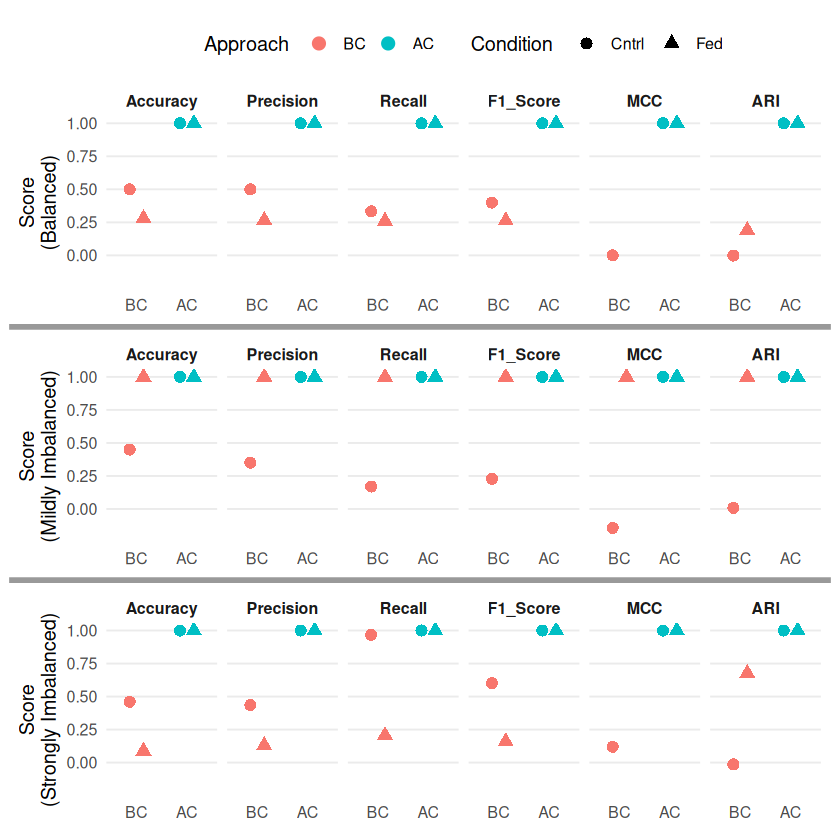

In [85]:
suppressPackageStartupMessages({
  library(dplyr)
  library(tidyr)
  library(stringr)
  library(ggplot2)
  library(scales)
  library(patchwork)
  library(grid)
})

# ---- 1) Validate expected columns ----
stopifnot(is.data.frame(metrics_res_full))
needed_cols <- c("Method", "Accuracy", "Precision", "Recall", "F1_Score", "MCC", "ARI")
stopifnot(all(needed_cols %in% colnames(metrics_res_full)))

# ---- 2) Robust parse: works for BOTH
# balanced_BC_Cntrl_2cls (4 tokens)
# mild_imbalanced_AC_Fed_2cls (5 tokens but first part includes underscore)
# ----
parsed <- metrics_res_full %>%
  mutate(
    Method = str_replace_all(as.character(Method), "\\s+", "")
  ) %>%
  tidyr::extract(
    Method,
    into = c("imbalance", "approach", "condition", "clusters"),
    regex = "^(balanced|mild_imbalanced|strong_imbalanced)_(BC|AC)_(Cntrl|Fed)_(\\d+cls)$",
    remove = FALSE
  )

# Fail fast if any method didn't match the expected pattern
bad_methods <- parsed %>%
  filter(is.na(imbalance) | is.na(approach) | is.na(condition) | is.na(clusters)) %>%
  distinct(Method) %>%
  pull(Method)

if (length(bad_methods) > 0) {
  stop(
    "These Method strings did not match the expected pattern:\n",
    paste0(" - ", bad_methods, collapse = "\n"),
    "\nExpected: (balanced|mild_imbalanced|strong_imbalanced)_(BC|AC)_(Cntrl|Fed)_(2cls|3cls|...)"
  )
}

# ---- 3) Long format metrics ----
plot_df <- parsed %>%
  pivot_longer(
    cols = c(Accuracy, Precision, Recall, F1_Score, MCC, ARI),
    names_to = "metric",
    values_to = "value"
  ) %>%
  mutate(
    imbalance = factor(imbalance, levels = c("balanced", "mild_imbalanced", "strong_imbalanced")),
    approach  = factor(approach,  levels = c("BC", "AC")),
    condition = factor(condition, levels = c("Cntrl", "Fed")),
    metric    = factor(metric, levels = c("Accuracy", "Precision", "Recall", "F1_Score", "MCC", "ARI"))
  ) %>%
  filter(!is.na(value))  # ensures missing combinations become "3 dots" instead of bogus points

# If you ever have multiple cluster settings and want ONLY 2cls, uncomment:
# plot_df <- plot_df %>% filter(clusters == "2cls")

# ---- 4) Plot function: 3|4 dots per panel (BC/AC color, Cntrl/Fed shape) ----
make_panel_plot <- function(df, facet_rows = TRUE) {
  g <- ggplot(
    df,
    aes(
      x = approach,
      y = value,
      color = approach,
      shape = condition,
      group = condition  # critical for consistent dodging
    )
  ) +
    geom_point(
      position = position_dodge(width = 0.55),
      size = 2.8,
      stroke = 0.9
    ) +
    scale_y_continuous(
      limits = c(-0.2, 1),
      breaks = seq(0, 1, by = 0.25),
      labels = label_number(accuracy = 0.01)
    ) +
    labs(x = NULL, y = "Score", color = "Approach", shape = "Condition") +
    theme_minimal(base_size = 12) +
    theme(
      panel.grid.minor = element_blank(),
      panel.grid.major.x = element_blank(),
      strip.text = element_text(face = "bold"),
      legend.position = "top"
    )

  if (facet_rows) {
    g <- g + facet_grid(imbalance ~ metric)
  } else {
    g <- g + facet_grid(. ~ metric)
  }
  g
}
# ---- 5) Build three blocks + horizontal separator lines ----
p_bal <- make_panel_plot(plot_df %>% filter(imbalance == "balanced"), facet_rows = FALSE) +
  theme(strip.text.y = element_blank()) +
  labs(y = "Score\n(Balanced)")

p_mild <- make_panel_plot(plot_df %>% filter(imbalance == "mild_imbalanced"), facet_rows = FALSE) +
  theme(strip.text.y = element_blank()) +
  labs(y = "Score\n(Mildly Imbalanced)")

p_strong <- make_panel_plot(plot_df %>% filter(imbalance == "strong_imbalanced"), facet_rows = FALSE) +
  theme(strip.text.y = element_blank()) +
  labs(y = "Score\n(Strongly Imbalanced)")

separator <- wrap_elements(
  full = rectGrob(gp = gpar(col = NA, fill = "grey60"))
) + theme_void()

p <- (p_bal / separator / p_mild / separator / p_strong) +
  plot_layout(heights = c(1, 0.035, 1, 0.035, 1), guides = "collect") &
  theme(legend.position = "top")

print(p)

# Optional save
ggsave("metrics_structured_fixed.png", p, width = 13, height = 7.5, dpi = 320)
# ggsave("metrics_structured_fixed.pdf", p, width = 13, height = 7.5, device = cairo_pdf)


In [33]:
# write metrics_res_full
write_delim(
    metrics_res_full,
    "./results/metrics_res_full.tsv",
    delim = "\t",
    col_names = TRUE
)

# plots

In [ ]:
library(tidyverse)

library(grid)
library(gridExtra)
library(patchwork)

source("../evaluation_utils/plots_eda.R")


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: viridisLite



In [ ]:
data_path <- "../evaluation_data/simulated_rotation/"

before_correction <- list()
central_corrected <- list()
fed_corrected <- list()
metadata <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    for (lab in c("lab1", "lab2", "lab3")) {
        # read in the data
        lab_data <- read.csv(paste0(data_path, mode, "/before/", lab, "/intensities.tsv"), sep = "\t", header = TRUE, check.names = F)
        # if before_correction[[mode]] is empty, initialize it
        if (is.null(before_correction[[mode]])) {
            before_correction[[mode]] <- lab_data
        } else {
            before_correction[[mode]] <- merge(before_correction[[mode]], lab_data, by = "rowname", all = TRUE)
        }
    }
    # before_correction[[mode]] <- read.csv(paste0(data_path, mode, "/all_intensities.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    before_correction[[mode]] <- before_correction[[mode]] %>% column_to_rownames("rowname")
    central_corrected[[mode]] <- read.csv(paste0(data_path, mode, "/after/runs/1_R_corrected.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    # fed_corrected[[mode]] <- read.csv(paste0(data_path, mode, "/after/FedApp_corrected_data_smpc.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    fed_corrected[[mode]] <- read.csv(paste0(data_path, mode, "/after/runs/1_FedSim_corrected.tsv"), sep = "\t", header = TRUE, row.names = 1, check.names = F)
    # fed_corrected[[mode]] <- central_corrected[[mode]]

    metadata[[mode]] <- read.csv(paste0(data_path, mode, "/all_metadata.tsv"), sep = "\t", header = TRUE, row.names = 1)

    # metadata[[mode]]$file <- rownames(metadata[[mode]])
    rownames(metadata[[mode]]) <- metadata[[mode]]$file
    metadata[[mode]]$condition <- as.factor(metadata[[mode]]$condition )
    metadata[[mode]]$lab <- as.factor(metadata[[mode]]$lab)

    # order the columns in intensity dataframes
    before_correction[[mode]] <- before_correction[[mode]][, rownames(metadata[[mode]])]
    central_corrected[[mode]] <- central_corrected[[mode]][rownames(before_correction[[mode]]), rownames(metadata[[mode]])]
    fed_corrected[[mode]] <- fed_corrected[[mode]][rownames(before_correction[[mode]]), rownames(metadata[[mode]])]

    cat(mode, "before correction:", nrow(before_correction[[mode]]), "rows\n")
    cat(mode, "after R correction:", nrow(central_corrected[[mode]]), "rows\n")
    cat(mode, "after FedSim correction:", nrow(fed_corrected[[mode]]), "rows\n")
    cat(mode, "metadata:", nrow(metadata[[mode]]), "rows\n\n")
}

balanced before correction: 6000 rows
balanced after R correction: 6000 rows
balanced after FedSim correction: 6000 rows
balanced metadata: 600 rows

mild_imbalanced before correction: 6000 rows
mild_imbalanced after R correction: 6000 rows
mild_imbalanced after FedSim correction: 6000 rows
mild_imbalanced metadata: 600 rows

strong_imbalanced before correction: 6000 rows
strong_imbalanced after R correction: 6000 rows
strong_imbalanced after FedSim correction: 6000 rows
strong_imbalanced metadata: 600 rows



In [ ]:
plot_pca_uncorrected <- list()
plot_pca_corrected <- list()

layouts <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced")){

    before_with_zeros <- before_correction[[mode]]
    before_with_zeros[is.na(before_with_zeros)] <- 0
    after_with_zeros <- fed_corrected[[mode]]
    after_with_zeros[is.na(after_with_zeros)] <- 0

    plot_pca_uncorrected[[mode]] <- pca_plot(
        before_with_zeros, metadata[[mode]],
        title = paste("Before correction"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=T, cbPalette=c("#a70a66", "#2a609d"),
        point_size = 1
        )

    plot_pca_corrected[[mode]] <- pca_plot(
        after_with_zeros, metadata[[mode]],
        title = paste("After FedRBE correction"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=F, cbPalette=c("#a70a66", "#2a609d"),
        point_size = 1
        )

    layout <- plot_pca_uncorrected[[mode]] /
              plot_pca_corrected[[mode]]
    layout <- layout + plot_annotation(paste0("PCA plots, simulated ", mode))
}



In [ ]:
options(repr.plot.width=5, repr.plot.height=7, dpi=600)

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced")) {
    plot_corrected_one <- plot_pca_corrected[[mode]] + 
        geom_point(size = 2, alpha = 0.8)

    plot_uncorrected_one <- plot_pca_uncorrected[[mode]] + 
        geom_point(size = 1.5, alpha = 0.7)


    # change the legend marker size (the kegend was added using theme(legend.position = "none"))
    plot_uncorrected_one <- plot_uncorrected_one +
        guides(
            colour = guide_legend(
            override.aes = list(size = 3)   # ← larger filled circles
            ),
            shape  = guide_legend(
            override.aes = list(size = 3)   # ← larger shape symbols
            )
        ) 

    layout <- plot_uncorrected_one /
              plot_corrected_one

    layout <- layout + plot_annotation(paste0("PCA plots, simulated ", mode))
    print(layout)
}